# Module 4: Practical 2 - Convolution Intuition

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Create a simple color flag image (France tricolor flag representation in RGB)
france = torch.tensor([
    [[0, 0, 0, 255, 255, 255, 255, 255, 255],  # Red channel
     [0, 0, 0, 255, 255, 255, 255, 255, 255],
     [0, 0, 0, 255, 255, 255, 255, 255, 255]],

    [[0, 0, 0, 255, 255, 255, 0, 0, 0],  # Green channel
     [0, 0, 0, 255, 255, 255, 0, 0, 0],
     [0, 0, 0, 255, 255, 255, 0, 0, 0]],

    [[255, 255, 255, 255, 255, 255, 0, 0, 0],  # Blue channel
     [255, 255, 255, 255, 255, 255, 0, 0, 0],
     [255, 255, 255, 255, 255, 255, 0, 0, 0]]
], dtype=torch.float32) # Shape: [C, H, W]


In [2]:
france.shape


torch.Size([3, 3, 9])

Note that we defined the 3 channels (Red, Green, Blue) in the first dimension. In order to visualize the image using matplotlib's imshow function we need to reshape the tensor to have the channel as the last dimension.

In [3]:
france.permute(1, 2, 0)


tensor([[[  0.,   0., 255.],
         [  0.,   0., 255.],
         [  0.,   0., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         [255.,   0.,   0.],
         [255.,   0.,   0.],
         [255.,   0.,   0.]],

        [[  0.,   0., 255.],
         [  0.,   0., 255.],
         [  0.,   0., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         [255.,   0.,   0.],
         [255.,   0.,   0.],
         [255.,   0.,   0.]],

        [[  0.,   0., 255.],
         [  0.,   0., 255.],
         [  0.,   0., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         [255.,   0.,   0.],
         [255.,   0.,   0.],
         [255.,   0.,   0.]]])

In addition, visualization libraries like matplotlib expect the pixel values to be in the range [0, 255] and of type uint8. We can convert the tensor to a numpy array and cast it to uint8 using the numpy method astype.

In [4]:
# Enable gridlines that align with the image cells
def visualize(image):
    print(image.shape)
    h, w = image.shape[:2]
    ax = plt.gca()
    ax.set_xticks(np.arange(-0.5, w, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, h, 1), minor=True)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(visible=True, which='minor', color='green', linewidth=0.5)
    ax.tick_params(which='minor', size=0)
    if (len(image.shape) == 2):
        plt.imshow(image, cmap = 'gray')
        for (i, j), val in np.ndenumerate(image):
            plt.text(j, i, f"{val:.0f}", ha='center', va='center', color='white' if val < 128 else 'black')
    else:
        plt.imshow(image)
    plt.show()


For this activity we will deal with a grayscale version of the France flag image. We can convert the image to grayscale by averaging the pixel values across the three channels. We can then visualize the grayscale image using the visualize function. Here we also use the squeeze method to remove the singleton dimension (C) from the tensor, since there is only one channel now.

In [5]:
france_grayscale = 0.2989 * france[0] + 0.5870 * france[1] + 0.1140 * france[2]


(3, 9)


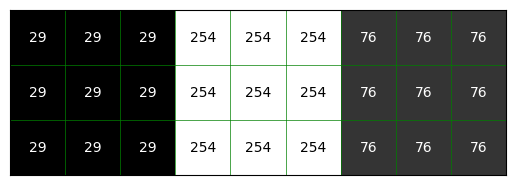

In [6]:
visualize(france_grayscale.squeeze().numpy().astype(np.uint8))


Next, let's create a filter to detect the vertical and horizontal edges in the image. Think about what happens as we slide it across the image while performing the convolution operation (taking linear combination of image values with the coefficients specified by the filter).  Note also the unsqueeze function which increases the tensor dimension. We need this since the conv2d function from torch is designed to work with 4D tensors (B x C x H x W)

In [7]:
# Define vertical and horizontal filters
vertical_filter = torch.tensor([
    [-1, 1],
    [-1, 1]
], dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, 2, 2]

horizontal_filter = torch.tensor([
    [-1, -1],
    [ 1,  1]
], dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, 2, 2]


Now let's calculate the convolution to detect any vertical changes in intensity.

torch.Size([2, 8])


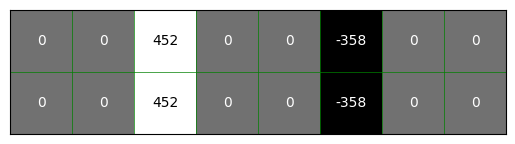

In [8]:
import torch
vertical_filter = torch.tensor([[-1, 1], [-1, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
horizontal_filter = torch.tensor([[-1, -1], [1, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
import torch.nn.functional as F

# Apply the vertical and horizontal filters
vertical_edges = F.conv2d(france_grayscale.unsqueeze(0), vertical_filter)
visualize(vertical_edges.squeeze())


Let's see what a flattened version of this tensor would look like.

torch.Size([1, 16])


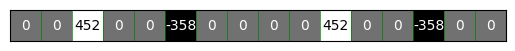

In [9]:
visualize(vertical_edges.flatten().unsqueeze(0))


In [10]:
def visualize_activations(flag, activation, activation_label):
    # Visualize the original flag and edge-detected images with colored edges
    plt.figure(figsize=(10, 4))

    # Original Flag
    plt.subplot(1, 3, 1)
    plt.imshow(flag.squeeze().numpy(), cmap='gray', vmin=0, vmax=255)
    plt.grid(visible=True, color='black', linewidth=0.5)
    plt.title("Original Flag")
    plt.axis('off')

    # Vertical Edges
    plt.subplot(1, 3, 2)
    plt.imshow(activation.squeeze().numpy(), cmap='Reds')
    plt.title(activation_label)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def process_flag_with_detector(flag, filter, detector, activation_label):
    edges = F.conv2d(flag.unsqueeze(0), filter)
    visualize_activations(flag, F.relu(edges * detector.reshape(2,8)), activation_label)
    flattened_edges = edges.flatten().unsqueeze(1)
    signal = F.relu(detector @ flattened_edges)
    return signal.squeeze()


Finally we can multiply each of the flattened outputs from the previous step with a vector that has positive values in positions where we want to detect positive outputs (or negative values in positions where we want to detect negative outputs).

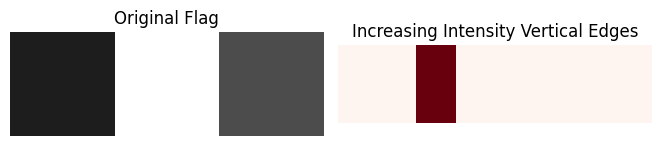

tensor(1885.9805)

In [11]:
process_flag_with_detector(france_grayscale, 
                           torch.tensor([
        [-1, 1],
        [-1, 1]
    ], dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, 2, 2]
    ,
                         torch.tensor(
                     [[0, 10, 10, 0, 0, 10, 10, 0,
                       0, 10, 10, 0, 0, 10, 10, 0]], dtype=torch.float32), activation_label = "Increasing Intensity Vertical Edges")


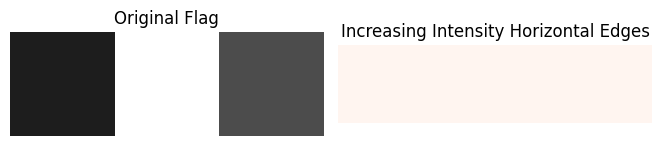

tensor(0.)

In [12]:
process_flag_with_detector(france_grayscale, 
                           torch.tensor([
        [1, 1],
        [-1, -1]
    ], dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, 2, 2]
    ,
                         torch.tensor(
                     [[0, 10, 10, 0, 0, 10, 10, 0,
                       0, 10, 10, 0, 0, 10, 10, 0]], dtype=torch.float32), activation_label = "Increasing Intensity Horizontal Edges")


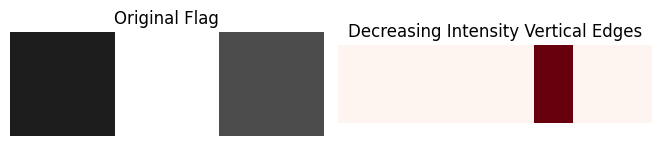

tensor(0.)

In [13]:
process_flag_with_detector(france_grayscale, 
                           torch.tensor([
        [-1, 1],
        [-1, 1]
    ], dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, 2, 2]
    ,
                         torch.tensor(
                     [[0, -10, -10, 0, 0, -10, -10, 0,
                       0, -10, -10, 0, 0, -10, -10, 0]], dtype=torch.float32), activation_label = "Decreasing Intensity Vertical Edges")


For this example we did some feature engineering by hardcoding the values into the filter, so it picks up the specific edges we were interested in. Convolutional Neural Networks use generic weights to represent the filters, thus "building" the features automatically based on minimizing the loss function.